# Lot Calculations

This notebook calculates parking stats for lots (everything besides street parking).

[OSMnx](https://github.com/gboeing/osmnx) is used to download and maniuplate data from [OpenStreetMap](https://www.openstreetmap.org/#map=15/41.8222/-71.4085) (OSM).

In [162]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11'

## Setup

Specify the area to look for and the type of footprints to look for. Here, we only want the Downtown Neighborhood, and we are only looking for footprints tagged as "amenity:parking" in OSM.

**Note:** You must supply a `place` string which returns a valid result in OSM. For this calculation, I manually had to create the "Dowtown" neighborhood from the [City's GIS](http://pvdgis.maps.arcgis.com/home/webmap/viewer.html?useExisting=1&layers=07555d51a34a4fa0a43e9c920f68970f). Other neighborhoods may or may not be on OSM. For example, Fox Point and College Hill are, but Upper South Providence is not.

In [6]:
place = "Downtown, Providence, RI, USA"

Because of the way OSM stores data and OSMnx retrieves it, we need to handle street parking separately from how we handle parking in lots, whether they be surface, underground, or multi-level.

### Lot Parking

We will use OSMnx to download "footprints." These are effectively polygons representing the shapes of lots in the neighborhood. Each shape is "tagged" (in OSM parlance) with various bits of information (surface type, capacity, etc.).

For OSMnx to retrieve the right footprints, we need to specify a type:

In [7]:
footprint_type = "parking"

Download the footprints from OSM, and them project them to UTM 19 via OSMnx (UTM Zone selected automatically):

In [8]:
footprints_unprojected = ox.footprints.footprints_from_place(place, footprint_type=footprint_type)
footprints = ox.project_gdf(footprints_unprojected)

`footprints_from_place` and `project_gdf` returnn GeoPandas `GeoDataFrame`s. Examine the first few entries of the latter:

In [9]:
footprints.head()

,nodes,amenity,building,capacity,capacity:disabled,name,parking,source,supervised,wikidata,...,addr:state,addr:street,description,fee,building:levels,layer,lit,smoothness,members,type
121498413,"[1359954107, 1359954080, 1359954126, 135995408...",parking,yes,2400,33,Rhode Island Convention Center,multi-storey,Bing,yes,Q7320906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535719,"[1549239929, 1549239995, 1549239920, 154923986...",parking,yes,NaN,NaN,Biltmore Garage,multi-storey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535724,"[1549239764, 3190088397, 1549239673, 154923959...",parking,yes,NaN,NaN,NaN,multi-storey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535769,"[1549239670, 7105448142, 7105448141, 154923954...",parking,yes,NaN,NaN,NaN,multi-storey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535777,"[1549239863, 7107873191, 1549239787, 154923972...",parking,yes,NaN,NaN,NaN,multi-storey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And take a look at the geometries (stored as [Shapely Polygons](https://shapely.readthedocs.io/en/stable/manual.html#polygons)).

In [10]:
footprints.geometry.head()

121498413    POLYGON ((299344.171 4633139.476, 299344.231 4...
141535719    POLYGON ((299480.300 4633065.483, 299518.656 4...
141535724    POLYGON ((299920.958 4632965.162, 299927.951 4...
141535769    POLYGON ((299345.605 4632950.568, 299388.869 4...
141535777    POLYGON ((299862.573 4633016.029, 299886.587 4...
Name: geometry, dtype: geometry

And plot these as well, using OSMnx's `plot_footprints` function:

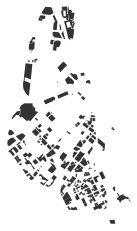

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122396890>)

In [11]:
ox.footprints.plot_footprints(footprints)

### Street Parking

Streets are defined as "ways" in OSM. Ideally, we would be able to pull these from OSM using the `osmnx.pois` module, but this is not currently possible because `osmnx.pois.create_poi_gdf` filters the dataset using the OSM `amenity` tag, which won't work since street parking is defined with the `parking:lane` tag. **Note:** [there is discussion](https://github.com/gboeing/osmnx/pull/342) on changing this in a future release of OSMnx.

Instead, we will get *all* OSM data as JSON, and filter to the ways we want.

First, we use `ox.gdf_from_place` to retrieve the geometry of the Downtown neighborhood:

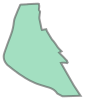

In [17]:
downtown_poly = ox.gdf_from_place("Downtown, Providence, RI, USA").geometry[0]
downtown_poly

Next, we extract the elements from this download, and filter:

In [109]:
download = ox.osm_net_download(polygon=downtown_poly)[0]['elements']

def is_way_with_parking(element):
    match_tags = ['parking:lane:both', 'parking:lane:left', 'parking:lane:right']
    
    return (element['type'] == 'way') and ('tags' in element) and (any(k in match_tags for k in element['tags'].keys()))

filtered = list(filter(is_way_with_parking, download))
filtered

[{'type': 'way',
  'id': 19371263,
  'nodes': [2462943205,
   201164458,
   201401172,
   201164445,
   4221450297,
   201401176,
   201312046,
   201401178],
  'tags': {'highway': 'primary',
   'lanes': '2',
   'name': 'North Main Street',
   'oneway': 'yes',
   'parking:lane:both': 'parallel',
   'ref': 'US 44',
   'surface': 'asphalt',
   'tiger:cfcc': 'A25',
   'tiger:name_base': 'Main',
   'tiger:name_base_1': 'United States Highway 1',
   'tiger:name_direction_prefix': 'N',
   'tiger:name_type': 'St',
   'tiger:reviewed': 'no'}},
 {'type': 'way',
  'id': 19375884,
  'nodes': [201319599,
   5689655376,
   201461429,
   201461427,
   201263932,
   201461424,
   201461411,
   5740722900,
   201461409,
   201381708],
  'tags': {'cycleway': 'no',
   'highway': 'tertiary',
   'lanes': '3',
   'name': 'Empire Street',
   'oneway': 'no',
   'parking:lane:left': 'parallel',
   'parking:lane:left:capacity': '10',
   'parking:lane:left:parallel': 'painted_area_only',
   'surface': 'paved',


Next, we use a Pandas `DataFrame` to store useful values from that JSON.

**Note:** this is Pandas, not GeoPandas. Currently, we are not storing any geospatial information about the streets.

In [171]:
sp = pd.DataFrame()

for f in filtered:
        osmid = f['id']
        tags = f.get('tags', {})
        tags_to_copy = ['surface', 'highway', 'lanes', 'oneway', 'parking', 'name']
        for t in tags.keys():
            if any(t.startswith(c) for c in tags_to_copy):
                sp.loc[osmid, t] = tags[t]

sp.head()

,highway,lanes,name,oneway,parking:lane:both,surface,parking:lane:left,parking:lane:left:capacity,parking:lane:left:parallel,parking:lane:right,parking:lane:right:capacity,parking:lane:right:parallel,parking:lane:both:capacity,parking:lane:both:parallel
19371263,primary,2,North Main Street,yes,parallel,asphalt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19375884,tertiary,3,Empire Street,no,NaN,paved,parallel,10,painted_area_only,NaN,NaN,NaN,NaN,NaN
90091975,residential,1,Westminster Street,yes,NaN,paved,NaN,NaN,NaN,parallel,66,on_street,NaN,NaN
547275326,unclassified,NaN,Washington Street,NaN,parallel,asphalt,NaN,NaN,NaN,NaN,NaN,NaN,10,painted_area_only
560205077,primary,2,North Main Street,yes,parallel,asphalt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculations

In [12]:
calculations = {'total': {}}  # Dictionary to hold all useful calculations

Let's get some basic calculations done first:

In [13]:
calculations['total']['count'] = len(footprints.index)
calculations['total']['area_naive'] = footprints.area.sum()  # Areas in square meters

calculations['total']

{'count': 208, 'area_naive': 358451.7241270884}

### Surface Lots

In [14]:
calculations['surface'] = {}

There's a lot of data to work with, and it's important to differentiate between different types of parking areas. For example, the area taken by a surface lot is used much less efficiently than it would by a multi-story lot.

Most of this data separation will be accomplished using the Pandas `query` function. For example, to filter the original footprints to entries that are surface lots:

In [15]:
filtered_surface = footprints.query("parking == 'surface'")
filtered_surface.head()

,nodes,amenity,building,capacity,capacity:disabled,name,parking,source,supervised,wikidata,...,addr:state,addr:street,description,fee,building:levels,layer,lit,smoothness,members,type
146047911,"[1593435262, 1593435285, 1593435350, 159343529...",parking,NaN,139,2,NaN,surface,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146047918,"[1593435488, 1593435458, 1593435230, 159343549...",parking,NaN,196,1,NaN,surface,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146047930,"[1593435352, 1593435214, 1593435342, 159343522...",parking,NaN,69,NaN,NaN,surface,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146047932,"[1593435493, 1593435452, 1593435400, 159343519...",parking,NaN,146,NaN,Empire Lot,surface,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146062999,"[1593530648, 1593530807, 1593530979, 159353103...",parking,NaN,140,8,Rhode Island Department of Transportation Park...,surface,survey,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
calculations['surface']['count'] = len(filtered_surface.index)
calculations['surface']['area'] = filtered_surface.area.sum()

calculations['surface']

{'count': 185, 'area': 251810.39049777057}